In [1]:
!nvidia-smi

Tue Jul 19 15:04:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip uninstall albumentations -y

Found existing installation: albumentations 0.1.12
Uninstalling albumentations-0.1.12:
  Successfully uninstalled albumentations-0.1.12


In [3]:
!pip install timm -q
!pip install albumentations -q

     |████████████████████████████████| 512 kB 5.1 MB/s 
     |████████████████████████████████| 116 kB 5.1 MB/s 
     |████████████████████████████████| 48.3 MB 1.8 MB/s 


In [5]:
cd drive/MyDrive/probspace/image_classification-japanese-painting/

/content/drive/MyDrive/probspace/image_classification-japanese-painting


In [7]:
!pip install "opencv-python-headless<4.3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [8]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import time
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import GroupKFold, StratifiedKFold

from datetime import datetime
from tqdm.autonotebook import tqdm as tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import roc_auc_score

import timm

In [13]:
DATA_DIR = "/content/drive/MyDrive/probspace/kaokore_status/data/"

In [14]:
train_labels = np.load(os.path.join(DATA_DIR, 'train_data.npz'))['arr_1']
train_labels = train_labels.astype('int64')
train_images = np.load(os.path.join(DATA_DIR, 'train_data.npz'))['arr_0']
test_images = np.load(os.path.join(DATA_DIR, 'test_data.npz'))['arr_0']

In [15]:
train_labels.shape, train_images.shape, test_images.shape

((6446,), (6446, 256, 256, 3), (2000, 256, 256, 3))

In [ ]:
class CFG:
    def __init__(self):
        
        self.debug=False
        self.num_workers=4
        self.model_name='efficientnet_b0'
        self.size=train_images.shape[1]
        self.scheduler='CosineAnnealingLR' 
        self.epochs= 20
        self.T_max=4
        self.lr=1e-3
        self.min_lr=1e-4
        self.batch_size= 16
        self.weight_decay=5e-5
        self.dropout=0.5
        self.seed=42
        self.n_fold=5
        self.alpha = 1.0
        self.device = torch.device('cuda')

CONFIG = CFG()

In [ ]:
def seed_everything(seed:int==42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CONFIG.seed)

In [16]:
class TrainDataset:
    
    def __init__(self, image, target, transform=None):
        
        self.image = image
        self.target = target
        self.transform = transform
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, item):
        
        image = self.image[item]
        target = self.target[item]
        
        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed['image']
            
        else:
            image = image[np.newaxis, :, :]

        return {
            'image' : torch.tensor(image, dtype=torch.float),
            'target' : torch.tensor(target, dtype=torch.float).long(),
        }

In [17]:
class TestDataset:
    
    def __init__(self, image, transform=None):
        
        self.image = image
        self.transform = transform
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, item):
        
        image = self.image[item]
        
        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed['image']
            
        else:
            image = image[np.newaxis, :, :]

        return {
            'image' : torch.tensor(image, dtype=torch.float),
        }

In [27]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])

In [28]:
class Model(nn.Module):
    
    def __init__(self, CONFIG, pretrained=False):
        super().__init__()
        self.CONFIG = CONFIG
        self.backbone = timm.create_model(self.CONFIG.model_name, 
                                          pretrained=pretrained,
                                          in_chans=3)
        
        self.n_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(self.n_features, 13)
        
        
    def forward(self, x):
        output = self.backbone(x)
        output = F.log_softmax(output, dim = 1)
        return output

In [29]:
def train_func(model, optimizer, scheduler, loss_fn, dataloader, device):
    
    model.train()
    final_loss = 0
    
    for step, data in enumerate(dataloader):
        
        s_t = time.time()
        optimizer.zero_grad()
        
        image = data['image'].to(device)
        label = data['target'].to(device)
        batch_size = label.size(0)
        
        preds = model(image)

        loss = loss_fn(preds, label)

        e_t = time.time()
        e_t = e_t - s_t

        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss

In [30]:
def valid_func(model, loss_fn, dataloader, device):
    
    model.eval()

    final_loss = 0
    valid_preds = []

    for step, data in enumerate(dataloader):
        
        s_t = time.time()
        image = data['image'].to(device)
        label = data['target'].to(device)

        preds = model(image)
            
        loss = loss_fn(preds, label)
        e_t = time.time()
        e_t = e_t - s_t

        valid_preds.append(preds.sigmoid().detach().cpu().numpy())
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

In [31]:
def test_func(model, dataloader, device):
    
    model.eval()
        
    final_loss = 0
    test_preds = []

    for step, data in enumerate(dataloader):
        
        s_t = time.time()
        image = data['image'].to(device)

        preds = model(image)
            
        e_t = time.time()
        e_t = e_t - s_t
        
        test_preds.append(preds.sigmoid().detach().cpu().numpy())
                
    test_preds = np.concatenate(test_preds)
    
    return test_preds

In [32]:
from sklearn.metrics import accuracy_score

CV = StratifiedKFold(n_splits=CONFIG.n_fold, random_state=CONFIG.seed, shuffle=True)

oof = np.zeros((train_images.shape[0], 13))
pred = np.zeros((test_images.shape[0], 13))

device = CONFIG.device

for fold, (tr, te) in enumerate(CV.split(train_images, train_labels)):

    print(f'==================== Fold {fold+1} ======================')

    tr_image = train_images[tr]
    va_image = train_images[te]

    tr_target = train_labels[tr]
    va_target = train_labels[te]


    train_dataset = TrainDataset(tr_image, tr_target, 
                                    get_transforms(data='train'))
    valid_dataset = TrainDataset(va_image, va_target,
                                    get_transforms(data='valid'))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=CONFIG.batch_size,
                                                num_workers=CONFIG.num_workers,
                                                pin_memory=True,
                                                shuffle=True)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                batch_size=CONFIG.batch_size,
                                                num_workers=CONFIG.num_workers,
                                                pin_memory=True,
                                                shuffle=False)
    

    model = Model(CONFIG, pretrained=True)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=CONFIG.lr,
                                  weight_decay=CONFIG.weight_decay)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max=CONFIG.T_max,
                                                         eta_min=CONFIG.min_lr,
                                                         last_epoch=-1)

    loss_fn = nn.CrossEntropyLoss()

    best_score = 0

    for epoch in range(CONFIG.epochs):

        start_time = time.time()
        train_loss = train_func(model, optimizer, scheduler,
                                loss_fn, train_loader, device)
        valid_loss, valid_preds = valid_func(model, loss_fn,
                                                valid_loader, device)

        score = accuracy_score(va_target, np.argmax(valid_preds, axis=1))

        end_time = time.time()
        print(f"FOLD: {fold+1} | EPOCH:{epoch+1:02d} | train_loss:{train_loss:.6f} | valid_loss:{valid_loss:.6f} | valid_score:{score:.4f} | time:{end_time-start_time:.1f}s ")


        if score > best_score:
            best_score = score
            oof[te] = valid_preds
                
            MODEL_PATH = f"{DATA_DIR}topic_001_baseline_{CONFIG.model_name}_fold{fold+1}.pth"
            torch.save(model.state_dict(), MODEL_PATH)

        else:
            continue


    del train_dataset, valid_dataset, train_loader, valid_loader, valid_preds
    _ = gc.collect()


    ## Predict
    model.load_state_dict(torch.load(MODEL_PATH))
    test_dataset = TestDataset(test_images,
                                 get_transforms(data='valid'))
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=CONFIG.batch_size,
                                              num_workers=CONFIG.num_workers,
                                              pin_memory=True,
                                              shuffle=False)
    test_preds = test_func(model, test_loader, device)
    pred += test_preds/CONFIG.n_fold

    del test_dataset, test_loader, model

==================== Fold 1 ======================
FOLD: 1 | EPOCH:01 | train_loss:0.660130 | valid_loss:0.488834 | valid_score:0.8163 | time:49.0s 
FOLD: 1 | EPOCH:02 | train_loss:0.397573 | valid_loss:0.384607 | valid_score:0.8543 | time:61.7s 
FOLD: 1 | EPOCH:03 | train_loss:0.284065 | valid_loss:0.399079 | valid_score:0.8550 | time:42.2s 
FOLD: 1 | EPOCH:04 | train_loss:0.225758 | valid_loss:0.480472 | valid_score:0.8465 | time:44.2s 
FOLD: 1 | EPOCH:05 | train_loss:0.183488 | valid_loss:0.558680 | valid_score:0.8457 | time:42.3s 
FOLD: 1 | EPOCH:06 | train_loss:0.167922 | valid_loss:0.476975 | valid_score:0.8543 | time:42.8s 
FOLD: 1 | EPOCH:07 | train_loss:0.120200 | valid_loss:0.544277 | valid_score:0.8566 | time:42.4s 
FOLD: 1 | EPOCH:08 | train_loss:0.122924 | valid_loss:0.560697 | valid_score:0.8543 | time:43.2s 
FOLD: 1 | EPOCH:09 | train_loss:0.123457 | valid_loss:0.568228 | valid_score:0.8651 | time:42.4s 
FOLD: 1 | EPOCH:10 | train_loss:0.099997 | valid_loss:0.749474 | va

In [34]:
oof_df = pd.DataFrame(columns=['target', 'pred'])
oof_df['target'] = train_labels
oof_df['pred'] = np.argmax(oof, axis=1).astype(int)

for i in range(13):
    oof_df[f'pred_{i}'] = oof[:, i]

oof_score = accuracy_score(oof_df['target'], oof_df['pred'])
oof_df.to_csv(os.path.join(DATA_DIR, f"baseline_{oof_score:.5f}.csv"), index=False)
print(f'OOF_Score: {oof_score:.6f}')

display(oof_df.head())

OOF_Score: 0.868446


,target,pred,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12
0,1,1,3.781683e-03,0.499048,4.889114e-07,3.453297e-06,8.979974e-09,1.494190e-08,1.030653e-08,1.259175e-08,1.061745e-08,1.155235e-08,1.105835e-08,1.520264e-08,1.255358e-08
1,1,1,1.869782e-12,0.500000,2.886680e-17,9.458819e-07,7.672429e-20,3.929173e-19,1.917009e-19,3.392034e-19,1.782737e-19,1.797912e-19,1.005031e-19,4.185089e-19,2.037767e-19
2,0,1,2.902709e-01,0.371455,4.900163e-07,3.485678e-05,1.060575e-07,9.503671e-08,8.804997e-08,1.027988e-07,8.484269e-08,1.192624e-07,1.289445e-07,1.060814e-07,1.091992e-07
3,3,3,2.223877e-03,0.013542,5.340492e-02,4.812241e-01,8.476672e-07,1.345288e-06,1.034615e-06,1.653735e-06,9.684866e-07,1.018179e-06,7.612708e-07,1.304661e-06,1.143642e-06
4,0,0,4.999949e-01,0.000020,4.467449e-17,9.789703e-13,2.614592e-17,4.693112e-17,4.203381e-17,5.988446e-17,2.273478e-17,2.407307e-17,2.620374e-17,3.944059e-17,3.839740e-17


In [35]:
pred_df = pd.DataFrame(columns=['id', 'y'])
pred_df['id'] = [i+1 for i in range(test_images.shape[0])]
pred_df['y'] = np.argmax(pred, axis=1).astype('int')

for i in range(13):
    pred_df[f'pred_{i}'] = pred[:, i]

## Submit
pred_df[['id', 'y']].to_csv(os.path.join(DATA_DIR, f"baseline_submit_{oof_score:.5f}.csv"), index=False)

## for Ensemble
pred_df.to_csv(os.path.join(DATA_DIR, f"baseline_pred_{oof_score:.5f}.csv"), index=False)

display(pred_df.head())

,id,y,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12
0,1,1,0.000005,0.499957,5.383206e-08,0.000165,1.108666e-09,1.758725e-09,1.828643e-09,2.566280e-09,1.426925e-09,1.651543e-09,1.330097e-09,2.219957e-09,1.666060e-09
1,2,1,0.177170,0.372627,1.222718e-04,0.000357,4.385527e-05,4.542758e-05,5.091556e-05,4.429624e-05,4.440148e-05,4.676150e-05,5.108481e-05,5.206670e-05,4.693560e-05
2,3,0,0.474215,0.043278,1.696333e-03,0.021954,5.195923e-05,3.807376e-05,4.820674e-05,4.846386e-05,4.937289e-05,4.911404e-05,6.245655e-05,4.771328e-05,6.155042e-05
3,4,2,0.053331,0.000088,4.778229e-01,0.000489,3.437789e-05,3.122261e-05,3.048266e-05,2.970017e-05,3.179767e-05,3.156428e-05,4.022310e-05,2.987927e-05,3.158153e-05
4,5,1,0.243278,0.310843,1.669138e-04,0.006916,7.986258e-05,9.029084e-05,9.058021e-05,8.611522e-05,9.689004e-05,9.099036e-05,1.108587e-04,9.296654e-05,1.041995e-04


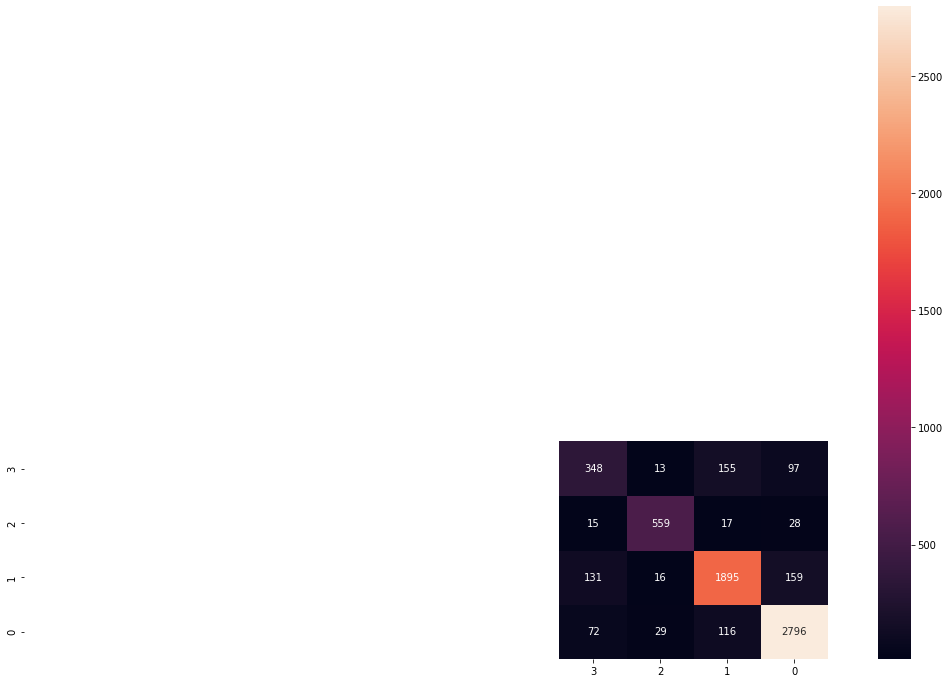

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(oof_df['target'], np.argmax(oof, axis=1).astype(int))

plt.figure(figsize=(18, 12))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlim(12, 0)
plt.ylim(0, 12)
plt.show()